## Import libraries

In [3]:
%matplotlib inline
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T   

## Setup Display

In [4]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

## Deep Q-Network

We define our DQN as a class that extends nn.Module. Our DQN will receive screenshot-like images of the cart and pole environment as input, so to create a DQN object, we’ll require the height and width of the image input that will be coming in to this model.

In [5]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()

        self.fc1 = nn.Linear(in_features=img_height*img_width*3, out_features=24)   
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=4)
    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t

## Experiennce 

 To create experiences, we creating a class called Experience.

In [6]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)

In [7]:
e = Experience(2,3,1,4)  
e

Experience(state=2, action=3, next_state=1, reward=4)

## Replay Memory

In [8]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    def push(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count % self.capacity] = experience # Overwriting the oldest experiences first
        self.push_count += 1
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

## Epsilon Greedy Strategy

In [9]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step * self.decay)

## RL Agent

In [10]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.current_step)
        self.current_step += 1

        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device) # explore      
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device) # exploit

## Environment Manager

This class will manage our cart and pole environment. It will wrap several of gym’s environment capabilities, and it will also give us some added functionality, like image preprocessing, for the environment images that will be given to our network as input.

In [11]:
class BreakoutEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('Breakout-v0').unwrapped
        self.env.reset()
        self.current_screen = None #start of the episode
        self.done = False #whether an episode has ended

#These functions reset, close and render using the gym's original 
#reset close and render functions
    def reset(self): #reset to starting state; returns initial observation
        self.env.reset()
        self.current_screen = None #Start of the new episode
    def close(self):
        self.env.close()
    def render(self, mode='rgb_array'): #returned in form of numpy array function
        return self.env.render(mode)
    
    def num_actions_available(self): # 2 actions (left or right)
        return 4
    
    def take_action(self, action):  # action is a tensor. .item() returns as a standard python number       
        _, reward, self.done, _ = self.env.step(action.item()) # first is observation, last is info
        return torch.tensor([reward], device=self.device) #tensor coming out
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self): 
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen) #making black screen of same dimensions as the current screen
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    def crop_screen(self, screen):
        screen_height = screen.shape[1]

        # Strip off top and bottom
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:, top:bottom, :]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)

        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])

        return resize(screen).unsqueeze(0).to(self.device) # add a batch dimension (BCHW)

## Example of non-processed screen

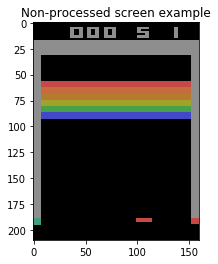

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
em = BreakoutEnvManager(device)
em.reset()
screen = em.render('rgb_array')
em.close()

plt.figure()
plt.imshow(screen)
plt.title('Non-processed screen example')
plt.show()

## Example of processed screen

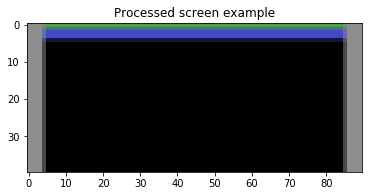

In [13]:
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Processed screen example')
plt.show()

## Example of starting state

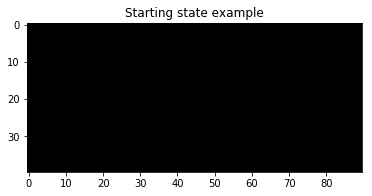

In [14]:
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Starting state example')
plt.show()

## Example of non-starting state

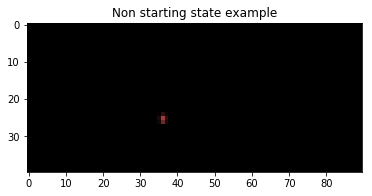

In [15]:
for i in range(5):
    em.take_action(torch.tensor([1]))
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Non starting state example')
plt.show()

## Example of end state

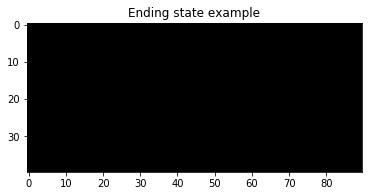

In [16]:
em.done = True
screen = em.get_state()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1, 2, 0).cpu(), interpolation='none')
plt.title('Ending state example')
plt.show()
em.close()

# Utility Functions

## Plotting

In [17]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    plt.plot(get_moving_average(moving_avg_period, values))
    plt.pause(0.001)
    if is_ipython: display.clear_output(wait=True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1) \
            .mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

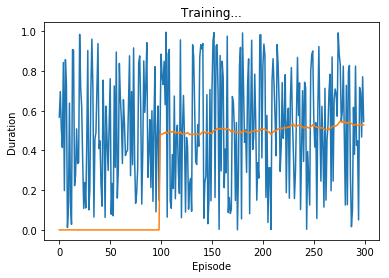

In [18]:
plot(np.random.rand(300), 100)

## Hyperparameters

In [ ]:
batch_size = 256
gamma = 0.999 # Discount factor in the bellman equation
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

# Essential Objects

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
em = BreakoutEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

In [22]:
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)

In [23]:
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

In [24]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=4, bias=True)
)

In [26]:
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

## Tensor processing

In [ ]:
def extract_tensors(experiences):
    # Convert batch of Experiences to Experience of batches
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1,t2,t3,t4)

In [30]:
e1 = Experience(1,1,1,1)
e2 = Experience(2,2,2,2)
e3 = Experience(3,3,3,3)

experiences = [e1,e2,e3]
experiences

[Experience(state=1, action=1, next_state=1, reward=1),
 Experience(state=2, action=2, next_state=2, reward=2),
 Experience(state=3, action=3, next_state=3, reward=3)]

In [32]:
batch = Experience(*zip(*experiences))
batch

Experience(state=(1, 2, 3), action=(1, 2, 3), next_state=(1, 2, 3), reward=(1, 2, 3))

## Calculating Q-Values

In [36]:
class QValues():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))
    @staticmethod        
    def get_next(target_net, next_states):                
        final_state_locations = next_states.flatten(start_dim=1) \
            .max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()
        return values

## Training Loop

In [25]:
episode_durations = []

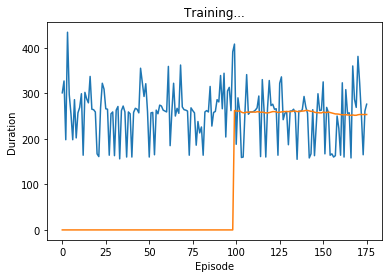

Episode 176 
 100 episode moving avg: 253.39


In [ ]:
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations, 100)
            break
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())
    em.close()

## Update to Plot

In [33]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()        
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)

    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)    
    plt.pause(0.001)
    print("Episode", len(values), "\n", \
        moving_avg_period, "episode moving avg:", moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

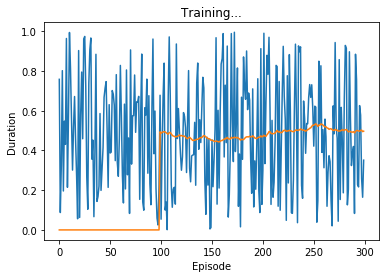

Episode 300 
 100 episode moving avg: 0.497283


In [34]:
plot(np.random.rand(300), 100)